In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from sklearn.mixture import GaussianMixture
import sys
np.seterr(invalid='ignore')

sys.path.insert(0, '/Users/vanessa/work/repos/pixel_classifier/src')

import pixel_classification as pc

In [2]:
def ber_demo():
    decision_bound = 1.5
    xr = np.linspace(-10, 10, 100)
    xr2 = np.linspace(decision_bound, 10, 100)
    xr1 = np.linspace(-10, decision_bound, 100)

    g1x,g1y = gaussian(xr,5,3, 1)
    pg1x,pg1y = gaussian(xr1,5,3, 1)
    g2x,g2y = gaussian(xr, 1,0,5)
    pg2x,pg2y = gaussian(xr2,1,0, 5)
    plt.axvline(x = decision_bound, color = 'k', label = 'axvline - full height')
    plt.fill_between(pg1x,pg1y, alpha=0.4,color='b')
    plt.fill_between(pg2x,pg2y, alpha=0.4,color='r')

    plt.plot(g1x, g1y,color='b')
    plt.plot(g2x, g2y,color='r')
    plt.plot(pg1x, pg1y,color='b')
    plt.plot(pg2x, pg2y,color='r')

    plt.annotate('Bayes Error for group 2 ', xy=(1.9, 0.2),  xycoords='data',
                xytext=(1.1, 0.95), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.01),
                horizontalalignment='right', verticalalignment='top',
                )
    plt.annotate('Bayes Error for group 1 ', xy=(1.2, 0.1),  xycoords='data',
                xytext=(0.5, 0.95), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.01),
                horizontalalignment='right', verticalalignment='top',
                )
    plt.title("Bayes Error Rate (BER)")
    plt.show()

In [3]:
def gaussian(x, amp, cen, wid):
    gx = []
    gy = []
    for xv in x:
        gx.append(xv)
        g = amp * np.exp(-(xv-cen)**2 / wid)
        gy.append(g)
    return gx,gy    

### Steps to generate masks
1. Read all images in a dark or water run

2. Parse images by gain mode and memory cell

3. Perform automated classification of pixels for each panel of each image 
    - Generate MAP or MLE for each distribution using EM 
        - Do it using 1 of 2 ways:
           - Bayesian Gaussian Mixture- infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution
           - Gaussian Mixture- estimate the parameters of a Gaussian mixture distribution.
         - Use Akaike information criterion (AIC) to determine number of Gaussian distributions
         - Assign which distribution belongs to the "good" pixel distribution:
              - criteria should include pi (should be large, at least >65%) and mean value being the closest to zero
    - Perform Naive Bayes classification for each pixel using MLE or MAP
    - Generate error estimate for this process
    - 2 outputs are returned using best Gaussian mixture model:
         - Mask map: Each pixel in a panel is assigned a value according to its "goodness":
             -good: 0, bad: 1 (could also add a value -1 for dead possibly)
         - Error map: Bayesian error rate associated with classification for each pixel in the panel
         
4. Collect data from each panel in each image
    - sum that masked pixels from panel over all images in a run
        - mask out pixels for which that pixel was masked some threshold that exceeds summed_pixel_value/num_images
        - possible to combine error statistics in a similar manner?
        
5. Generate mask using data from step 4



### Pixel masking will be performed using a Naive Bayes Classifier for each panel in an image

Classes of pixels will be determined using a Gaussian Mixture Model and the parameters of each Gaussian distribution will be determined using the expectation maximixation algorithm

#### Naive Bayes Classification is calculated:

$$ P(theta_k | data_i) = \frac{P(theta_k) * P(data_i | theta_k)}{\sum P(theta_k) * P(data_i| theta_k)}, \\ $$ 

where

$$data_i$$ 

isn't raw or normalized pixel intensities, but rather transformations of these pixel intensities. In this case we are using, bilateral regularization. There are many, many other ways to approach this, but I think the main goal is to choose a transformation that will yield easly computed statistical distributions (Gaussian, etc.). 

Bilateral regularization is performed as:

#### X<sub>(l,m)</sub> = X − S<sup>l</sup><sub>x</sub>S<sup>m</sup><sub>y</sub> X

S = operators that shift matrix X by l,m

l = integer shift in horizontal direction and m = integer shift in vertical direction

No reflection at borders

### How are errors estimated? 

There are at least two errors associated with this overall approach. 
1.  The error associated with the EM algortithm:
    - Exactly equal to or proportional to the Hessian (or Fisher Information Matrix)
2. The error associated with the Naive Bayes classification:

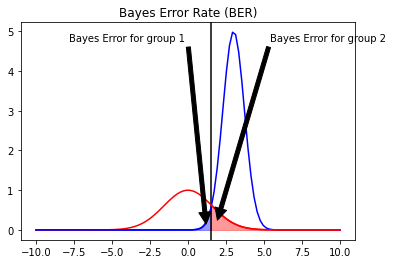

In [4]:
ber_demo()

### Mock workflow
#### Step 3. Perform automated classification of pixels for each panel of each image (ignore steps 2 and 3 for now) 
#####  Data will be a panel from a single image of a water run from the LDAP detector

In [10]:
cwd = os.getcwd()
panel_mat = np.load(os.path.join('/Users/vanessa/work/repos/pixel_masking/','data', 'run44_image0_gain2', 'panel_data_19_gain_1counts_3891.npy'))
#panel_mat = np.nan_to_num(panel_mat,nan=0.0)

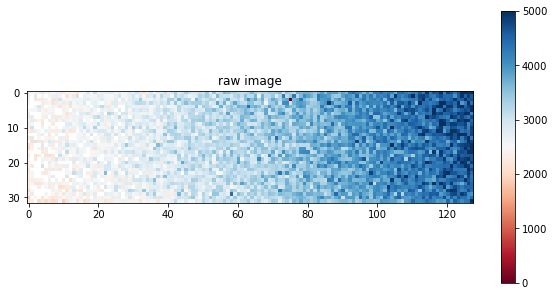

In [11]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.set_title("raw image")
p1 = ax.imshow(panel_mat,vmin=0, vmax=5000,cmap='RdBu');
f.colorbar(p1,ax=ax);


In [12]:
#scaled = panel_mat/np.std(panel_mat)
pix_classes = pc.pixel_classifier(panel_mat,IC_threshold=50, rescale_data=True,avg_off_gain_pixels=True)

EM algorithm converged?: True
Found 1 different distributions in best Gaussian mixture model
means: [0.02311517249578543]
variances: [1.0000009997592576]


In [13]:
classed_image = pix_classes.label_bad_pixels()

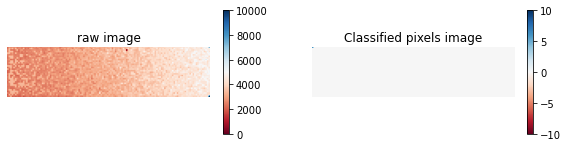

In [14]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(221)
ax.set_title("raw image")
p1 = ax.imshow(panel_mat,vmin=np.min(panel_mat.flatten()), vmax=np.max(panel_mat.flatten()),cmap='RdBu');
f.colorbar(p1,ax=ax);
ax.axis('off');
ax2 = f.add_subplot(222)
ax2.set_title("Classified pixels image")
p2 = ax2.imshow(classed_image,vmin=-10, vmax=10,cmap='RdBu');
f.colorbar(p2,ax=ax2);
ax2.axis('off');